In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/home/tim/Desktop/Desktop/DELFT/APPLIED PHYSICS - MASTER/Modeling and Data Analysis in Complex Networks/ASSIGNMENTS/ASSIGNMENT 1/SFHH2025.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Create an undirected graph from the dataset
G = nx.Graph()

# Add edges, ignoring time steps
edges = df[['id1', 'id2']].drop_duplicates().values.tolist()
G.add_edges_from(edges)

# 1. Number of nodes (N)
N = len(G.nodes())

# 2. Number of links (L)
L = len(G.edges())

# 3. Compute degree of each node
degrees = np.array([d for _, d in G.degree()])

# 4. Compute the average degree E[D]
E_D = np.mean(degrees)

# 5. Compute the standard deviation of the degree sqrt(Var[D])
std_D = np.std(degrees)

# Print results
print("Number of nodes (N):", N)
print("Number of links (L):", L)
print("Average degree (E[D]):", E_D)
print("Standard deviation of the degree (sqrt(Var[D])):", std_D)


Number of nodes (N): 401
Number of links (L): 9415
Average degree (E[D]): 46.957605985037404
Standard deviation of the degree (sqrt(Var[D])): 29.918521078014955


A2

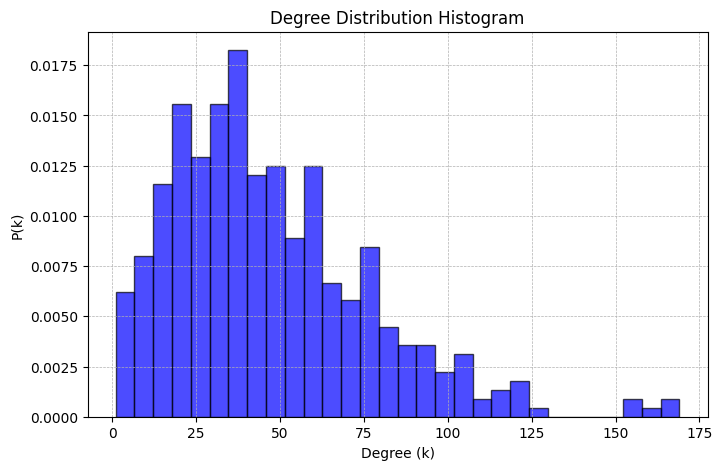

In [5]:
# Compute degree of each node
degrees = np.array([d for _, d in G.degree()])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=30, color="blue", alpha=0.7, edgecolor="black", density=True)

# Set y-axis to log scale
# plt.yscale("log")

# Labels and title
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution Histogram")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Looks like ER random model --> needs further assessment

A3

In [6]:
assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity coefficient (ρD):", assortativity)

Degree assortativity coefficient (ρD): -0.08190596963063947


ρ D <0 (Disassortative Mixing): High-degree nodes tend to connect to low-degree nodes. This is often seen in technological and biological networks (e.g., power grids, metabolic networks).If your dataset represents a contact network, a positive assortativity (ρD>0ρ D​	 >0) suggests that individuals with many contacts tend to interact with other well-connected individuals. A negative assortativity (ρD<0ρ D<0) suggests that well-connected individuals interact more frequently with those who have fewer connections, which is often seen in epidemic spread models.

A4

In [7]:
clustering_local = nx.clustering(G)  # Returns a dictionary {node: c_i}
C_avg = nx.average_clustering(G)
print("Average clustering coefficient (C):", C_avg)

Average clustering coefficient (C): 0.2812358620467742


A5

In [8]:
E_H = nx.average_shortest_path_length(G)
print("Average hopcount (E[H]):", E_H)
H_max = nx.diameter(G)
print("Network diameter (Hmax):", H_max)

Average hopcount (E[H]): 1.9547007481296759
Network diameter (Hmax): 4


Physical Meaning
Small E[H]E[H] → The network is well-connected; on average, nodes are close to each other.Large E[H]E[H] → Nodes are far apart, meaning communication or spreading processes take more steps.Small Hmax⁡H max​	  → The network is compact; the worst-case path is short.Large Hmax⁡H max​	  → The network has long chains or poorly connected parts.

A6

In [9]:
E_H = nx.average_shortest_path_length(G)
print("Average shortest path length (E[H]):", E_H)
C = nx.average_clustering(G)
print("Clustering coefficient (C):", C)
N = G.number_of_nodes()
L = G.number_of_edges()
C_random = L / (N * (N - 1) / 2)
print("Expected clustering coefficient for random network (C_random):", C_random)

Average shortest path length (E[H]): 1.9547007481296759
Clustering coefficient (C): 0.2812358620467742
Expected clustering coefficient for random network (C_random): 0.11739401496259351


A7

In [10]:
# Extract the link weights from the dataset
weights = df.groupby(['id1', 'id2']).size().values  # Counts occurrences per (id1, id2) pair

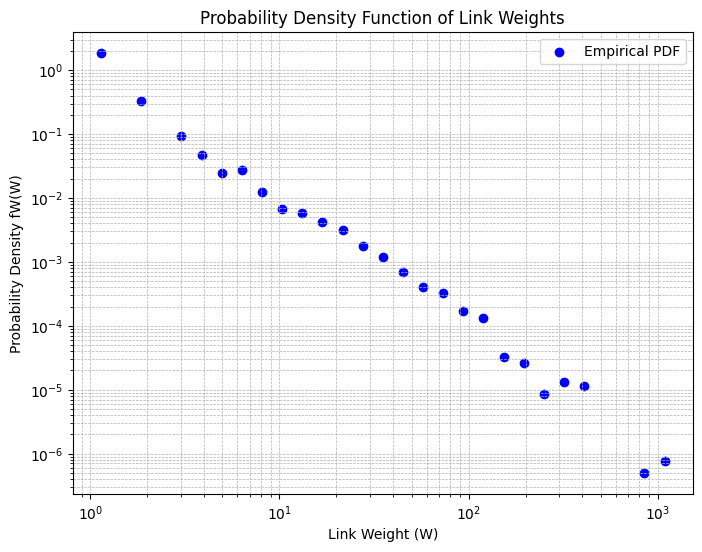

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define binning strategy: Use logarithmic bins for better power-law visibility
bins = np.logspace(np.log10(min(weights)), np.log10(max(weights)), num=30)

# Compute histogram
hist, bin_edges = np.histogram(weights, bins=bins, density=True)

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot PDF
plt.figure(figsize=(8,6))
plt.scatter(bin_centers, hist, marker='o', label="Empirical PDF", color="blue")

# Log-log scale for power-law analysis
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Link Weight (W)")
plt.ylabel("Probability Density fW(W)")
plt.title("Probability Density Function of Link Weights")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


The PDF represents the probability of encountering a link with a given weight.

In [12]:
import powerlaw

# Fit power-law model
fit = powerlaw.Fit(weights)

# Get exponent alpha
alpha = fit.power_law.alpha

Calculating best minimal value for power law fit


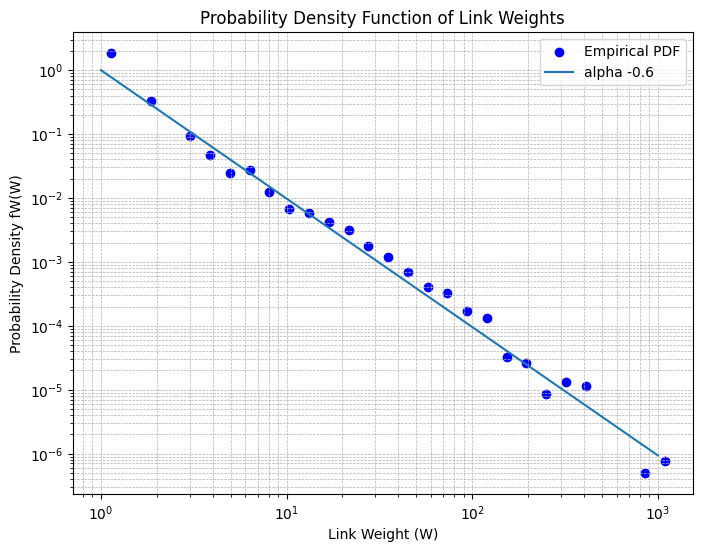

In [13]:
xvalues = np.logspace(0,3,5)
yvalues = xvalues**-(alpha-0.6)

plt.figure(figsize=(8,6))
plt.scatter(bin_centers, hist, marker='o', label="Empirical PDF", color="blue")
plt.plot(xvalues,yvalues, label= 'alpha -0.6')

# Log-log scale for power-law analysis
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Link Weight (W)")
plt.ylabel("Probability Density fW(W)")
plt.title("Probability Density Function of Link Weights")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

B8


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the temporal network data
# Assuming Gdata is a list of tuples (time, node_i, node_j)
Gdata = df[['time_step', 'id1', 'id2']].values.tolist()

# Parameters
N = G.number_of_nodes()  # Number of nodes
T = 3493  # Last time step

def simulate_spreading(seed, Gdata, T):
    infected = set([seed])
    I_t = np.zeros(T + 1)
    I_t[0] = 1  # Seed is infected at t=0

    contacts = defaultdict(list)
    for time, node_i, node_j in Gdata:
        contacts[time].append((node_i, node_j))

    for t in range(1, T + 1):
        new_infected = set()
        for node_i, node_j in contacts[t]:
            if node_i in infected and node_j not in infected:
                new_infected.add(node_j)
            elif node_j in infected and node_i not in infected:
                new_infected.add(node_i)
        infected.update(new_infected)
        I_t[t] = len(infected)

    return I_t

# Run simulations
all_I_t = np.zeros((N, T + 1))
for seed in range(N):
    all_I_t[seed] = simulate_spreading(seed, Gdata, T)

# Calculate average and standard deviation
E_I_t = np.mean(all_I_t, axis=0)
Var_I_t = np.std(all_I_t, axis=0)

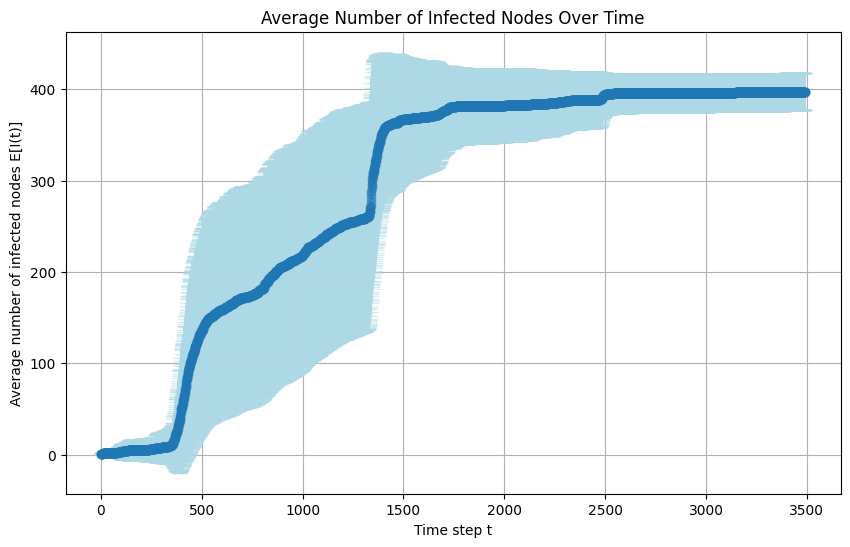

In [19]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(range(T + 1), E_I_t, yerr=Var_I_t, fmt='-o', ecolor='lightblue', alpha=0.5, capsize=5)
plt.xlabel('Time step t')
plt.ylabel('Average number of infected nodes E[I(t)]')
plt.title('Average Number of Infected Nodes Over Time')
plt.grid(True)
plt.show()

B9

In [29]:
# Parameters
N = G.number_of_nodes()  # Number of nodes
T = 3493  # Last time step
threshold = 0.8 * N  # 80% of the nodes

# Calculate the time to infect 80% of the nodes for each seed
time_to_infect_80 = np.full(N, T + 1)  # Initialize with a value greater than T
for seed in range(N):
    I_t = simulate_spreading(seed, Gdata, T)
    if np.any(I_t >= threshold):
        time_to_infect_80[seed] = np.argmax(I_t >= threshold)

# Rank the nodes based on the time to infect 80% of the nodes
ranked_nodes = np.argsort(time_to_infect_80)
R = ranked_nodes + 1  # Node indices start from 1

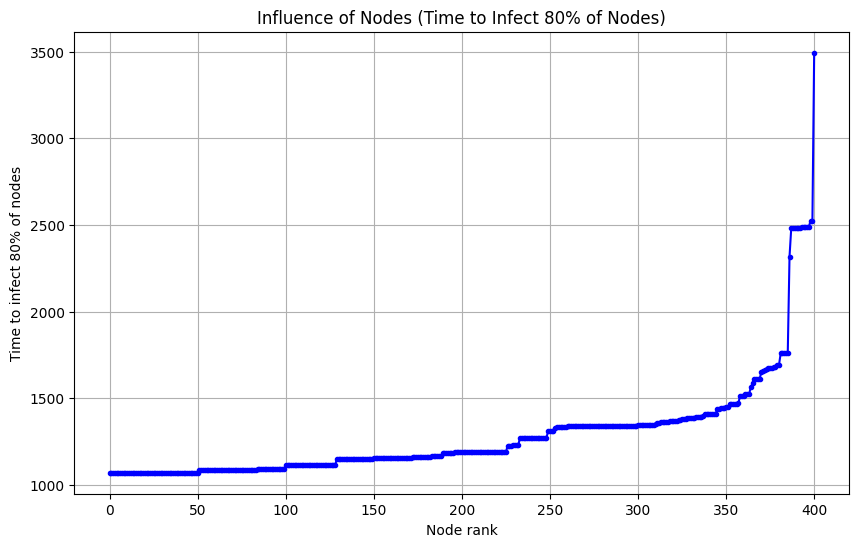

Ranking vector R: [ 17  34  35  36  40  44  43  42  46  47  48  45  49  55  52  53  65  61
  59  54  57  60  58  69  66  26  28   7   3   2  31  30  12  13  10  11
  14   6   9  19  27  20  18  25  24  23  22  21  15   8  16  76  74  73
  72  77  81  38  39  62  75  70  56  71  96  41 103 100 118 119  80 102
  68 126 101  87  99  98  95  82  78  79  67  88 130 131 104 133 108 109
 107 106 114 112 134 105 128 115 111 132 135 145  86 116 139 138 137 136
 141 142  84  85  94  93 120 110  90  89  92  91   4 127 113 123   5  83
 129 146 152 124 125 144 143  64  63 157 148 154 151 150 149 147 155 161
 163 162 166 184 168 165  50 122 117 190 192 159  51 121 140  97  29 185
 181 180 186 191 195 197 196 194 198 199 187 189 160  32  33 201 202 193
 188 164  37 182 153 178 167 158 156 179 209 208 183 200 203 205 215 204
 206 207 213 214 177 171 176 173 174 175 170 232 169 217 224 220 223 222
 221 212 218 219 216 211 231 227 172 228 225 226 233 234 210 236 241 235
 239 238 237 240 230 229 242 244 

In [30]:
# Plot the influence of each node in decreasing order
plt.figure(figsize=(10, 6))
plt.plot(np.sort(time_to_infect_80), '.-', color='blue')
plt.xlabel('Node rank')
plt.ylabel('Time to infect 80% of nodes')
plt.title('Influence of Nodes (Time to Infect 80% of Nodes)')
plt.grid(True)
plt.show()

# Print the ranking vector R
print("Ranking vector R:", R)

B10